# Preamble

In [49]:
using LinearAlgebra, ForwardDiff, DifferentialEquations, Plots
default(framestyle=:box, guidefont=font(14), titlefont=font(14), tickfont=font(12), legend_font=font(12), legend=false, linewidth=3);

In [2]:
Threads.nthreads()

1

In [3]:
lambda = 0.01;
xiG = 0;
xig = 4089;
alpha = (3e+4)^2/3;

n = 5;
xn = 4;

In [4]:
function metric(x)
    metric = zeros(eltype(x), n, n)
    
    xr2 = sum([x[i]^2 for i=1:xn])
    
    for i=1:xn, j=1:xn
        metric[i,j] = exp(-sqrt(2/3)*x[5])*(==(i,j) - 6*xiG^2*x[i]*x[j]/(1+xiG*xr2)) 
    end 
        
    metric[n,n] = 1
    
    return metric
end;

function viel(x)
    e,u = eigen(inv(metric(x)))
    return u*Diagonal([sqrt(ee) for ee in e])*inv(u)
end;

function gijk(x)
    metricdiff = ForwardDiff.jacobian(metric, x)
    gijk = [metricdiff[(i-1)*5+j,k] for i=1:n, j=1:n, k=1:n]
    return gijk
end;

function gijkl(x) 
    gijkl = zeros(eltype(x),n,n,n,n)
    
    for i=1:n, j=1:n
        gij(x) = metric(x)[i,j]
        gijhess = ForwardDiff.hessian(gij, x)
        
        for k=1:n, l=1:n
            gijkl[i,j,k,l] = gijhess[k,l]
        end;
    end;

    return gijkl
end;

function invgijk(x)
    invmetric = inv(metric(x))
    metricdiff = gijk(x)
    
    return [-invmetric[i,:]' * metricdiff[:,:,k] * invmetric[j,:] for i=1:n, j=1:n, k=1:n]
end;

function affine(x)
    invmetric = inv(metric(x))
    metricdiff = gijk(x)
    
    return [1/2*sum([invmetric[i,s]*(metricdiff[s,j,k] + metricdiff[s,k,j] - 
                    metricdiff[k,j,s]) for s=1:n]) for i=1:n, j=1:n, k=1:n]
end;

function Gammaijkl(x)
    invmetric = inv(metric(x))
    metricdiff = gijk(x)
    invgdiff = invgijk(x)
    ghess = gijkl(x)
    
    return [1/2*
        sum([invgdiff[i,s,l] * (metricdiff[s,j,k] + metricdiff[s,k,j] - metricdiff[k,j,s]) +
                invmetric[i,s]*(ghess[s,j,k,l] + ghess[s,k,j,l] - ghess[k,j,s,l]) 
                for s=1:n]) for i=1:n, j=1:n, k=1:n, l=1:n]
end;
    
function riemann(x)
    affinediff = Gammaijkl(x)
    Gamma = affine(x)
    
    return [affinediff[i,j,l,k] - affinediff[i,j,k,l] +
        sum([Gamma[s,j,l]*Gamma[i,k,s] - Gamma[s,j,k]*Gamma[i,l,s] for s=1:n]) 
        for i=1:n, j=1:n, k=1:n, l=1:n]
end;

function potU(x)
    xr2 = sum([x[i]^2 for i=1:xn])
    
    return lambda/4*exp(-2*sqrt(2/3)*x[5])*xr2^2 + 
        1/4/alpha*(1-exp(-sqrt(2/3)*x[5])*(1+(xig+xiG)*xr2))^2
end;

Uprime(x) = ForwardDiff.gradient(potU,x);

function Upp(x)
    invmetric = inv(metric(x))
    Gamma = affine(x)
    Up = Uprime(x)
    Uhess = ForwardDiff.hessian(potU,x)
    
    return invmetric * (Uhess - [sum([Gamma[k,i,j]*Up[k] for k=1:n]) for i=1:n, j=1:n])
end;

kin(x,p) = 1/2*p'*metric(x)*p;

Hubble(x,p) = sqrt((kin(x,p) + potU(x))/3);

eH(x,p) = kin(x,p)/Hubble(x,p)^2;

# Background

In [10]:
function bgEoM(du, u, params, t) # u[1:n] = x, u[n+1:2n] = p = dx/dt, u[2n+1] = N
    x = u[1:n]
    p = u[n+1:2*n]
    H = Hubble(x,p)
    invmetric = inv(metric(x))
    Gamma = affine(x)
    Up = Uprime(x)
    
    for i=1:n
        du[i] = p[i]
        du[i+n] = -p'*Gamma[i,:,:]*p - 3*H*p[i] - invmetric[i,:]'*Up
    end;
    
    du[2*n+1] = H;
end;

ui = [0.08,0,0,0,4,0,0,0,0,0,0];
Hi = Hubble(ui[1:n],ui[n+1:2*n]);
tf = 50/Hi;
tspan = (0,tf);

bgprob = ODEProblem(bgEoM,ui,tspan,0);
@time bgsol = solve(bgprob,Tsit5(),reltol=1e-10,abstol=1e-10);

 26.799923 seconds (372.84 M allocations: 14.771 GiB, 3.91% gc time, 0.06% compilation time: 100% of which was recompilation)


In [79]:
x1list = [bgsol[i][1] for i=1:length(bgsol.t)];
ylist = [bgsol[i][5] for i=1:length(bgsol.t)];
Nlist = [bgsol[i][11] for i=1:length(bgsol.t)];
Hlist = [Hubble(bgsol[i][1:5],bgsol[i][6:10]) for i=1:length(bgsol.t)];
eHlist = [eH(bgsol[i][1:5],bgsol[i][6:10]) for i=1:length(bgsol.t)];
aHlist = [exp(Nlist[i])*Hlist[i] for i=1:length(bgsol.t)];

x1sol(t) = bgsol(t)[1];
ysol(t) = bgsol(t)[5];

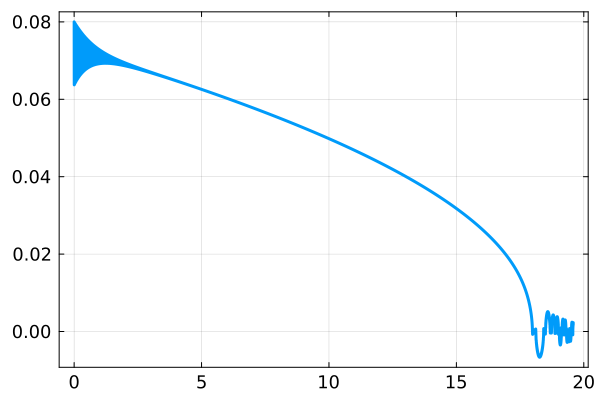

In [53]:
plot(Nlist,x1list)

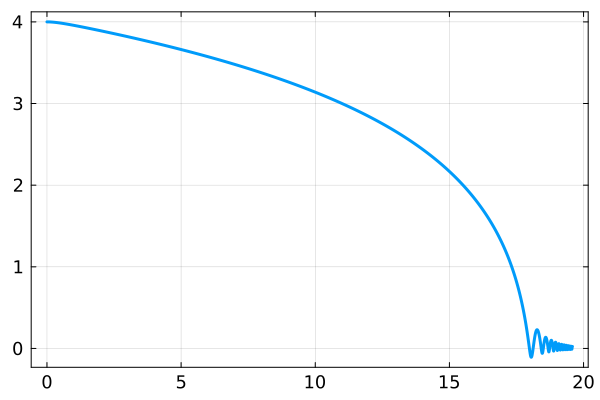

In [54]:
plot(Nlist,ylist)

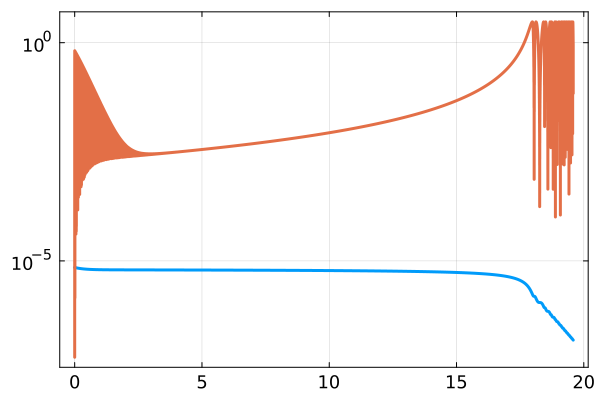

In [62]:
plot(Nlist,Hlist,yscale=:log10)
plot!(Nlist[2:end],eHlist[2:end])

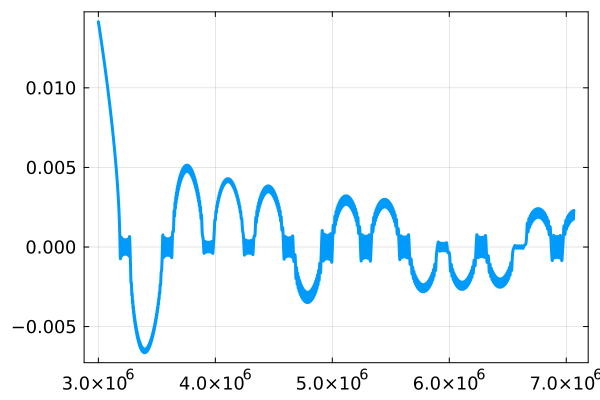

In [84]:
tzoom = [t for t in bgsol.t if 3e+6 < t];
plot(tzoom,map(x1sol,tzoom))

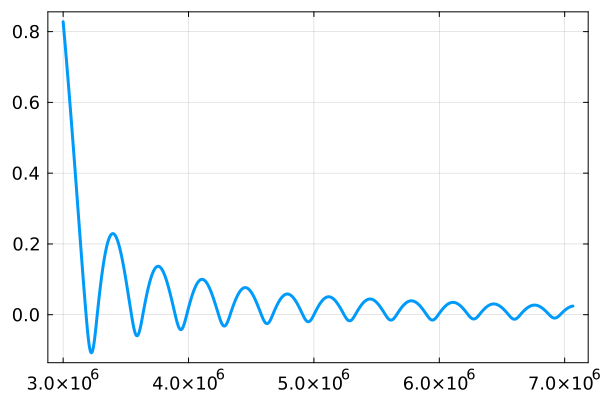

In [85]:
plot(tzoom,map(ysol,tzoom))

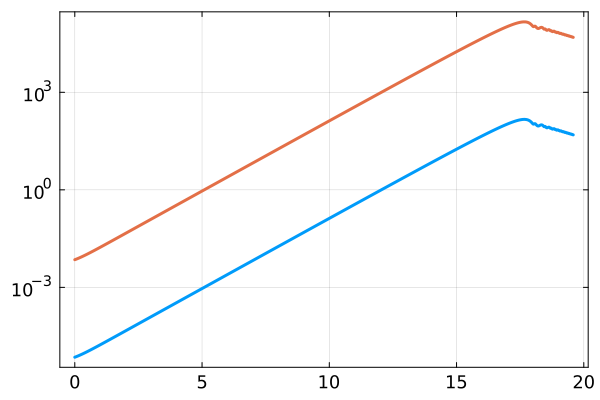

In [87]:
plot(Nlist,aHlist,yscale=:log10)
plot!(Nlist,1000*aHlist,yscale=:log10)

# Perturbation